# Modelo de Asignación

## Implementación

In [1]:
!python -m pip install -i https://pypi.gurobi.com gurobipy
!pip install haversine

from haversine import haversine
from gurobipy import*
import pandas as pd

# Cargar Datos
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')
ejeX = list(coord_df['Longitud'])
ejeY = list(coord_df['Latitud'])
u = []
for j in range(len(ejeX)):
  u.append((ejeY[j], ejeX[j])) # Ubicación de cada finca

# Definir los conjuntos
n = 180 # Número de fincas
m = 2 # Número de plantas postcosecha
F = [i for i in range(n)] # Fincas
P = [j for j in range(m)] # Plantas

# Definir los parámetros
# Distancia entre cada finca y cada planta post cosecha (km)
centrosIniciales = [(7.019472, -71.384889), (6.6, -71.65)]
contFinca = 0
d = {}
for fincaAct in u:
  contCentro = 0
  for centro in centrosIniciales:
    # Vector con las distancias entre la finca actual y cada planta post cosecha
    d[(contFinca, contCentro)] = haversine(fincaAct, centro)
    contCentro += 1
  contFinca += 1


# Capacidad de procesamiento de cada planta (ton)
c = [1300, 600]

# Producción de cada finca (ton)
p = list(produccion['Producción'])

# Crear el modelo
modeloAsignacion = Model('Asignación')

# Crear las variables de decisión
x = modeloAsignacion.addVars(F, P, vtype = GRB.BINARY)

# Restricciones del Problema
# La producción de las fincas no puede superar la capacidad de las plantas
for j in P:
  modeloAsignacion.addConstr(quicksum(x[i, j] * p[i] for i in F) <= c[j])
# Cada finca sólo puede ser asignada a una única planta
for i in F:
  modeloAsignacion.addConstr(quicksum(x[i, j] for j in P) == 1)

# Función Objetivo
modeloAsignacion.setObjective(quicksum(x[i, j] * d[i, j] for i in F for j in P), GRB.MINIMIZE)

# Resolver
modeloAsignacion.optimize()
print('\n')

Looking in indexes: https://pypi.gurobi.com, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 182 rows, 360 columns and 720 nonzeros
Model fingerprint: 0x5ace6674
Variable types: 0 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [8e-01, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 6914.5418037
Presolve removed 182 rows and 360 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Expl

## Resultados

Función Objetivo: 4714.898200083451


Total Fincas Planta 1 = 85


Total Fincas Planta 2 = 95




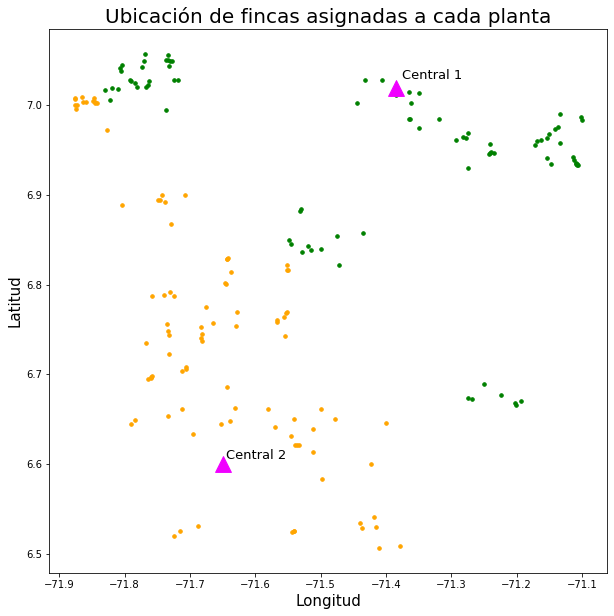

In [2]:
import matplotlib.pyplot as plt

# Imprimir y graficar los resultados
print(f'Función Objetivo: {modeloAsignacion.getObjective().getValue()}')
print('\n')
for j in P:  
  cP = 0
  for i in F:
    if x[i, j].x == 1:
      cP += 1
  print(f'Total Fincas Planta {j+1} = {cP}')
  print('\n')  


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

colores = ('green', 'orange')
for j in P:
  for i in F:
    if x[i, j].x == 1:
      plt.scatter(u[i][1], u[i][0], color = colores[j], marker = ".", s = 50)

plt.xlabel('Longitud', fontsize = 15)
plt.ylabel('Latitud', fontsize = 15)
plt.title('Ubicación de fincas asignadas a cada planta', fontsize = 20)
plt.scatter(centrosIniciales[0][1], centrosIniciales[0][0], color = (240/255, 0/255, 255/255), marker = "^", s = 250)
plt.annotate('Central 1', (-71.374889, 7.029472), fontsize = 13)
plt.scatter(centrosIniciales[1][1], centrosIniciales[1][0], color = (240/255, 0/255, 255/255), marker = "^", s = 250)
plt.annotate('Central 2', (-71.645, 6.605), fontsize = 13)
plt.show()